# Bitcoin

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


#### Preprocessing Steps

In [3]:
# bitcoin = pd.read_csv('bitcoin_original.csv')
# bitcoin = bitcoin.drop(columns=['Unnamed: 0'])
# for name in bitcoin.columns[1:-2]:
#     bitcoin[name] = bitcoin[name].str.replace(',', '').astype(float)
# bitcoin['Date'] = pd.to_datetime(bitcoin['Date'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
# bitcoin = bitcoin.sort_values('Date')
# bitcoin['Average'] = (bitcoin['High'] + bitcoin['Low']) / 2
# bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
# bitcoin.head()

In [4]:
bitcoin_data = pd.read_csv('data/bitcoin/bitcoin_preprocessed.csv', parse_dates=['Date'])

In [5]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5282 non-null   datetime64[ns]
 1   Price     5282 non-null   float64       
 2   Open      5282 non-null   float64       
 3   High      5282 non-null   float64       
 4   Low       5282 non-null   float64       
 5   Vol.      5276 non-null   object        
 6   Change %  5282 non-null   object        
 7   Average   5282 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 330.3+ KB


In [6]:
bitcoin_data.describe()

,Date,Price,Open,High,Low,Average
count,5282,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,2017-10-09 12:00:00,13991.793601,13973.960621,14301.911473,13630.541746,13966.226609
min,2010-07-18 00:00:00,0.100000,0.000000,0.100000,0.000000,0.050000
25%,2014-02-27 06:00:00,236.325000,236.225000,240.300000,232.325000,236.250000
50%,2017-10-09 12:00:00,3694.250000,3688.400000,3826.400000,3611.800000,3727.825000
75%,2021-05-21 18:00:00,20759.675000,20725.975000,21307.025000,20256.025000,20796.437500
max,2025-01-01 00:00:00,106138.900000,106140.700000,108244.900000,105350.600000,106797.750000
std,NaN,20663.596560,20634.796513,21096.208461,20162.686270,20626.123003


In [7]:
bitcoin_data.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        6
Change %    0
Average     0
dtype: int64

---

#### Dropping columns

In [9]:
bitcoin_data.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Average'], dtype='object')

In [10]:
columns_to_drop = ['Open', 'High', 'Low', 'Vol.', 'Change %', 'Average']
bitcoin = bitcoin_data.drop(columns=columns_to_drop)
bitcoin

,Date,Price
0,2010-07-18,0.1
1,2010-07-19,0.1
2,2010-07-20,0.1
3,2010-07-21,0.1
4,2010-07-22,0.1
...,...,...
5277,2024-12-28,95284.5
5278,2024-12-29,93716.3
5279,2024-12-30,92779.8
5280,2024-12-31,93557.2


#### Stationarity check - Augmented Dickey–Fuller test and stationarity checks

In [17]:
adf_test = adfuller(bitcoin['Price'])
print("ADF statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical values:", adf_test[4])

if adf_test[1] < 0.05:
    print("Reject the null hypothesis - series is stationary")
else:
    print("Fail to reject the null hypothesis - series is non-stationary")

ADF statistic: 0.131258568083941
p-value: 0.9681315896984167
Critical values: {'1%': np.float64(-3.4315966656699595), '5%': np.float64(-2.862090897148884), '10%': np.float64(-2.567063242235428)}
Fail to reject the null hypothesis - series is non-stationary


In [18]:
bitcoin['Close_Diff'] = bitcoin['Price'].diff()  # Difference of close prices
bitcoin['Close_Log'] = np.log(bitcoin['Price'])  # Log of close prices
bitcoin['Close_Log_Diff'] = bitcoin['Close_Log'].diff()  # Difference of Log of close prices

In [19]:
bitcoin.head()

,Price,Close_Diff,Close_Log,Close_Log_Diff
Date,,,,
2010-07-18,0.1,NaN,-2.302585,NaN
2010-07-19,0.1,0.0,-2.302585,0.0
2010-07-20,0.1,0.0,-2.302585,0.0
2010-07-21,0.1,0.0,-2.302585,0.0
2010-07-22,0.1,0.0,-2.302585,0.0


Drop the NaN values created by differencing

In [21]:
bitcoin.dropna(subset=['Close_Diff', 'Close_Log', 'Close_Log_Diff'], inplace=True)
bitcoin.head()

,Price,Close_Diff,Close_Log,Close_Log_Diff
Date,,,,
2010-07-19,0.1,0.0,-2.302585,0.0
2010-07-20,0.1,0.0,-2.302585,0.0
2010-07-21,0.1,0.0,-2.302585,0.0
2010-07-22,0.1,0.0,-2.302585,0.0
2010-07-23,0.1,0.0,-2.302585,0.0


In [24]:
bitcoin.tail()

,Price,Close_Diff,Close_Log,Close_Log_Diff
Date,,,,
2024-12-28,95284.5,1008.6,11.464622,0.010642
2024-12-29,93716.3,-1568.2,11.448027,-0.016595
2024-12-30,92779.8,-936.5,11.437984,-0.010043
2024-12-31,93557.2,777.4,11.446328,0.008344
2025-01-01,94560.2,1003.0,11.456992,0.010664


In [34]:
series_list = {
    'Close_Diff': bitcoin['Close_Diff'],
    'Close_Log': bitcoin['Close_Log'],
    'Close_Log_Diff': bitcoin['Close_Log_Diff']
}

for label, series in series_list.items():
    adf_p_value = adf_test(series)
    if adf_p_value < 0.05:
        print(f"{label} is stationary, with p-value: {adf_p_value}")
    else:
        print(f"{label} is non-stationary, with p-value: {adf_p_value}")

Close_Diff is stationary, with p-value: 9.738414654421886e-18
Close_Log is stationary, with p-value: 0.04777617977605868
Close_Log_Diff is stationary, with p-value: 1.3121581533047221e-20


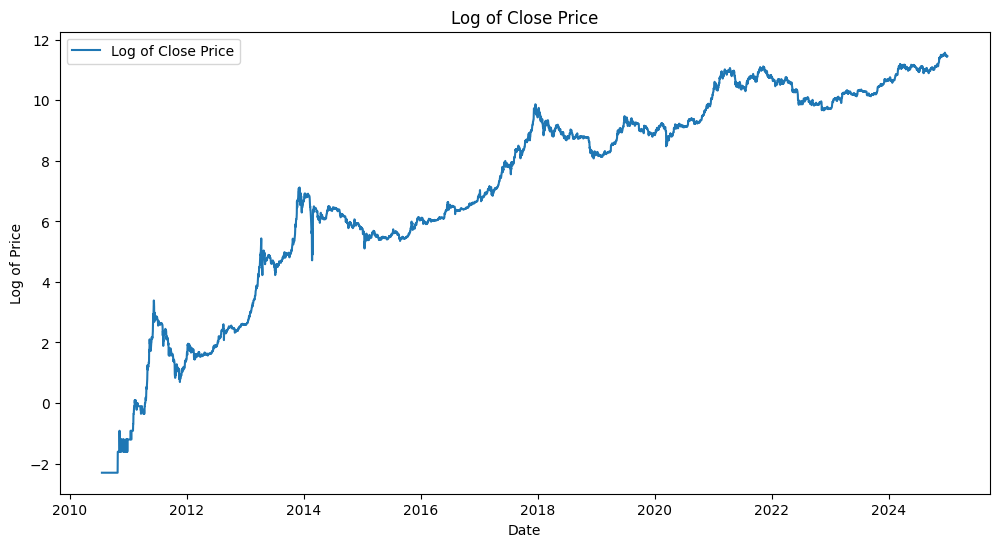

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin['Close_Log'], label='Log of Close Price')
plt.title('Log of Close Price')
plt.xlabel('Date')
plt.ylabel('Log of Price')
plt.legend()
plt.show()

In [36]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series):
    result = kpss(series, regression='c')  # 'c' for constant (Level Stationarity)
    return result[1] 


for label, series in series_list.items():
    kpss_p_value = kpss_test(series)
    if kpss_p_value < 0.05:
        print(f"{label} is non-stationary according to KPSS, with p-value: {kpss_p_value}")
    else:
        print(f"{label} is stationary according to KPSS, with p-value: {kpss_p_value}")


Close_Diff is stationary according to KPSS, with p-value: 0.06656885362449091
Close_Log is non-stationary according to KPSS, with p-value: 0.01
Close_Log_Diff is non-stationary according to KPSS, with p-value: 0.045886378106857494


C:\Users\maria\AppData\Local\Temp\ipykernel_26180\1417732603.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c')  # 'c' for constant (Level Stationarity)


In [37]:
def kpss_test_with_trend(series):
    result = kpss(series, regression='ct')  # 'ct' for trend stationarity
    return result[1]

for label, series in series_list.items():
    kpss_p_value = kpss_test_with_trend(series)
    if kpss_p_value < 0.05:
        print(f"{label} is non-stationary according to KPSS (trend), with p-value: {kpss_p_value}")
    else:
        print(f"{label} is stationary according to KPSS (trend), with p-value: {kpss_p_value}")


Close_Diff is stationary according to KPSS (trend), with p-value: 0.1
Close_Log is non-stationary according to KPSS (trend), with p-value: 0.01
Close_Log_Diff is stationary according to KPSS (trend), with p-value: 0.1


C:\Users\maria\AppData\Local\Temp\ipykernel_26180\1984181836.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='ct')  # 'ct' for trend stationarity
C:\Users\maria\AppData\Local\Temp\ipykernel_26180\1984181836.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='ct')  # 'ct' for trend stationarity
C:\Users\maria\AppData\Local\Temp\ipykernel_26180\1984181836.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='ct')  # 'ct' for trend stationarity


In [25]:
def plot_decomposition(series, model, title):
    decomposition = seasonal_decompose(series, model=model, period=365)
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.suptitle(title, fontsize=16)
    plt.show()

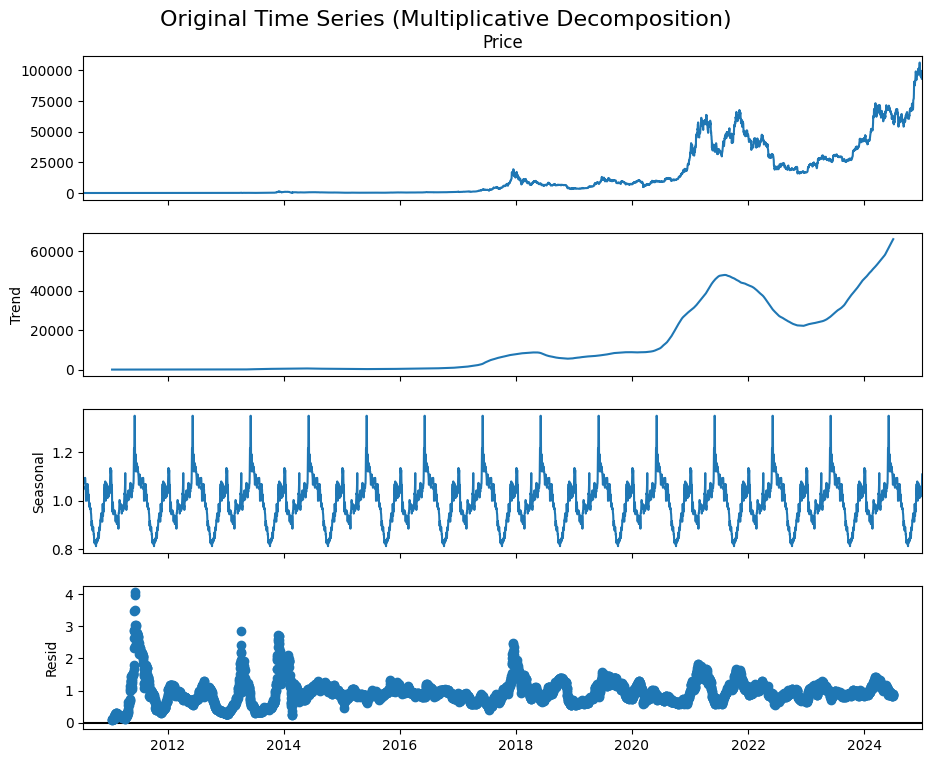

In [26]:
plot_decomposition(bitcoin['Price'], model='multiplicative', title="Original Time Series (Multiplicative Decomposition)")


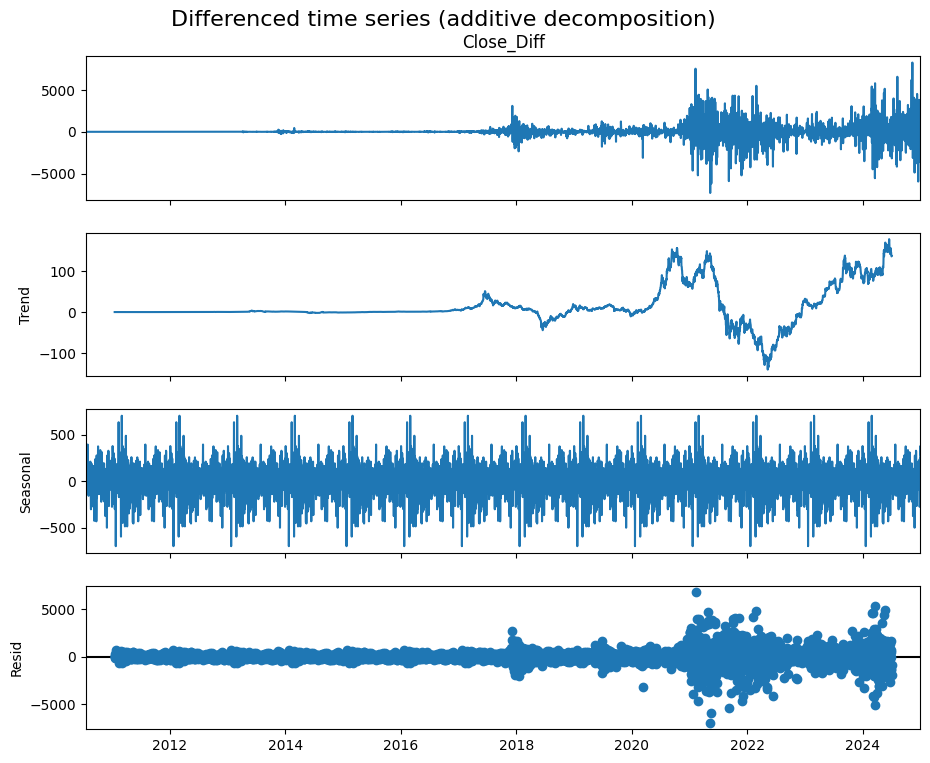

In [27]:
plot_decomposition(bitcoin['Close_Diff'], model='additive', title="Differenced time series (additive decomposition)")


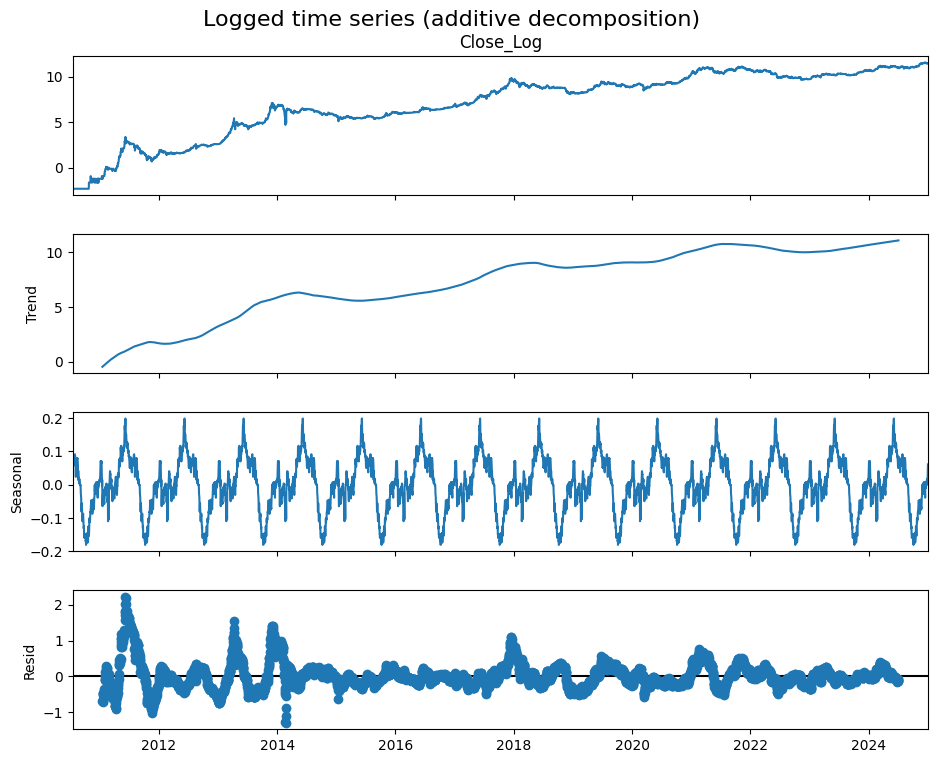

In [28]:
plot_decomposition(bitcoin['Close_Log'], model='additive', title="Logged time series (additive decomposition)")


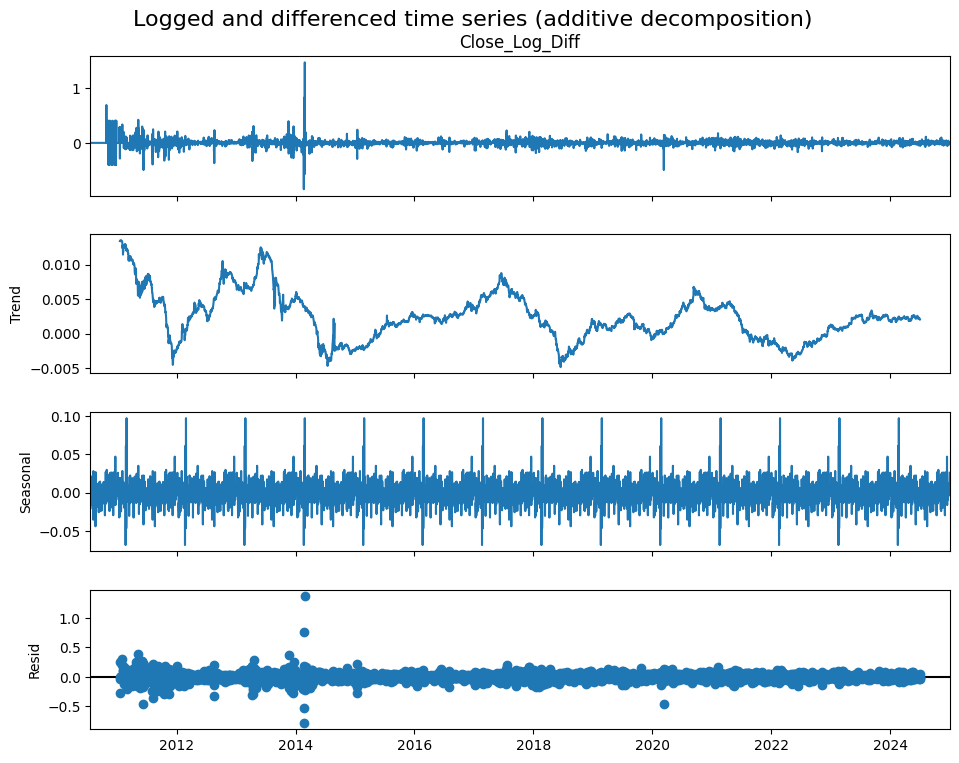

In [29]:
plot_decomposition(bitcoin['Close_Log_Diff'], model='additive', title="Logged and differenced time series (additive decomposition)")


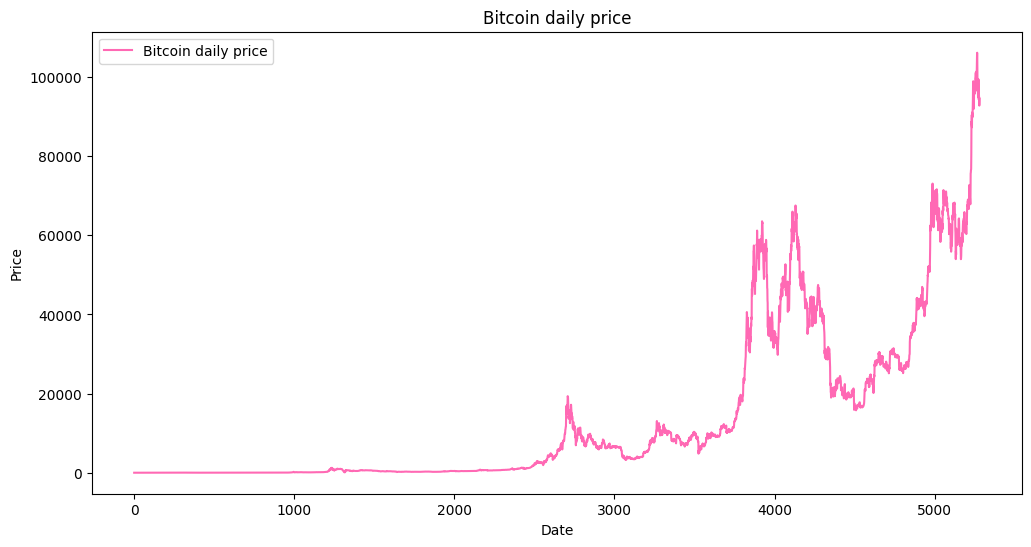

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin.index, bitcoin['Price'], label='Bitcoin daily price', color='hotpink')
plt.title('Bitcoin daily price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Visualizing the prediction accuracy by the volume data available. The more data, the more precise the trend line is.

In [12]:
bitcoin.set_index('Date', inplace=True)
df_monthly = bitcoin.resample('ME').mean()
df_annual = bitcoin.resample('YE').mean()
df_quarterly = bitcoin.resample('QE').mean()


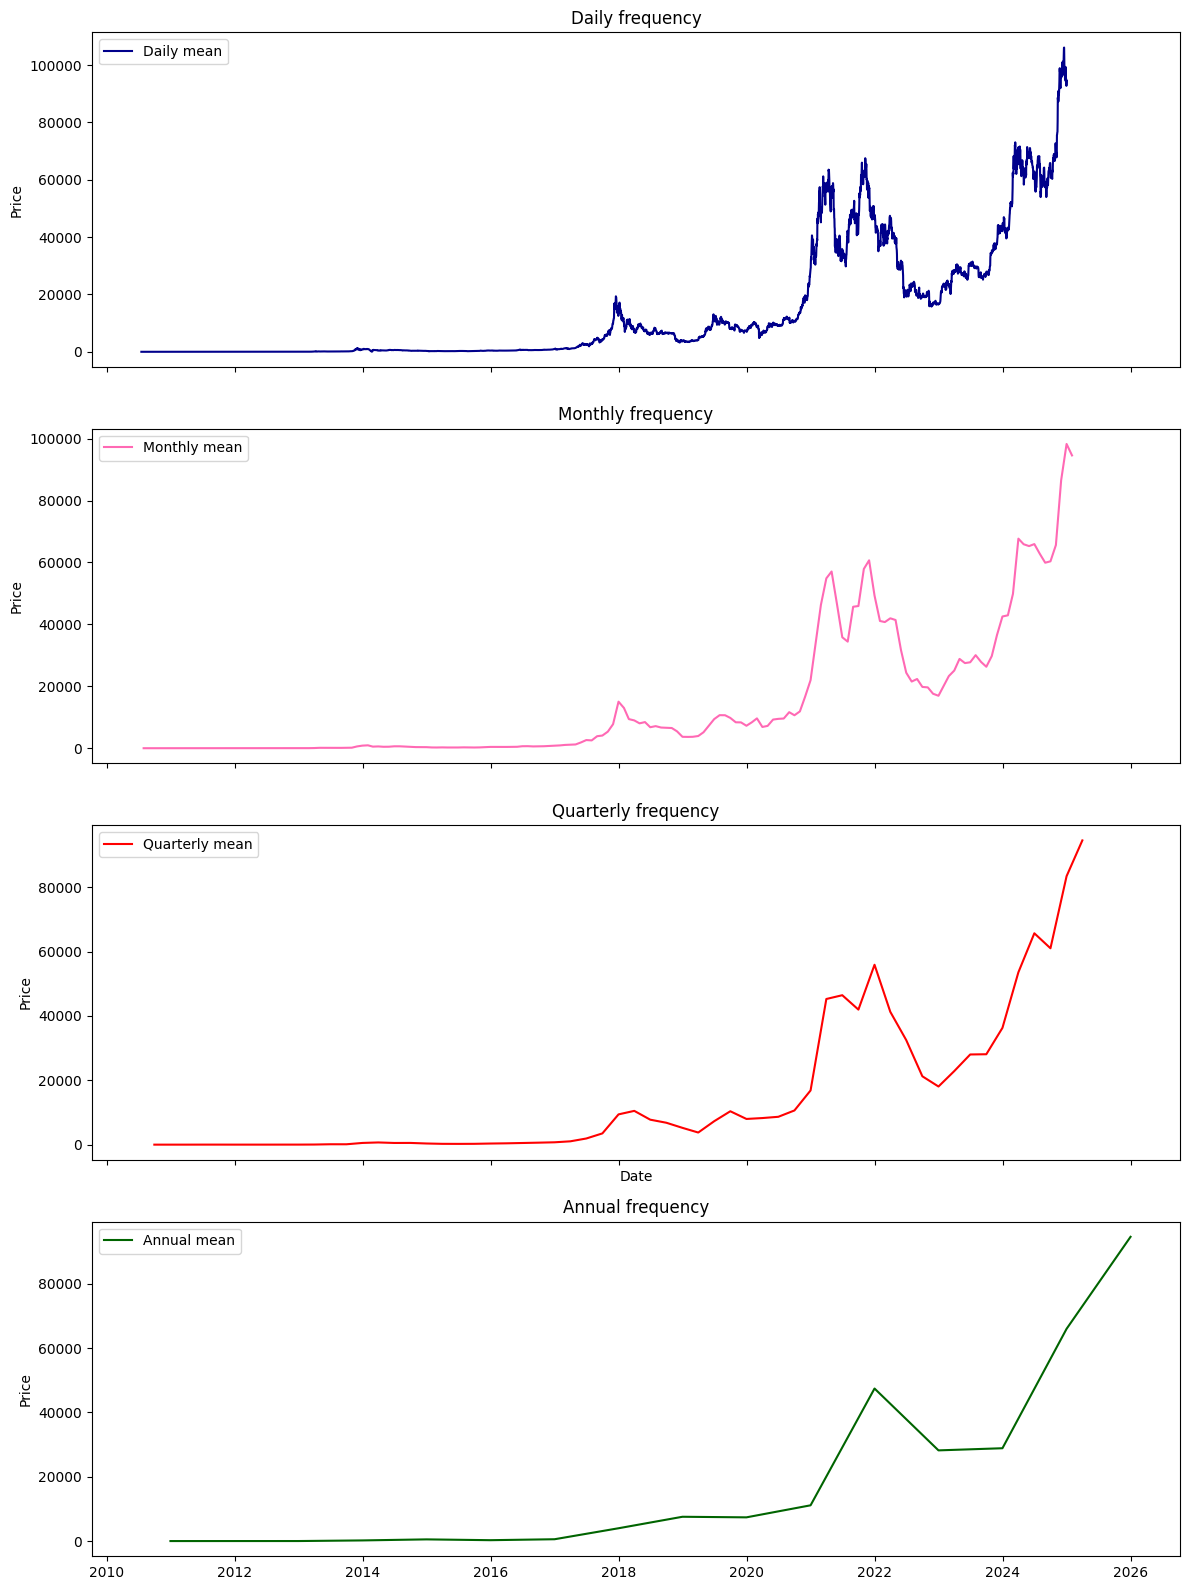

In [13]:
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
axs[0].plot(bitcoin.index, bitcoin['Price'], label='Daily mean', color='darkblue')
axs[0].set_title('Daily frequency')
axs[0].set_ylabel('Price')
axs[0].legend()

axs[1].plot(df_monthly.index, df_monthly['Price'], label='Monthly mean', color='hotpink')
axs[1].set_title('Monthly frequency')
axs[1].set_ylabel('Price')
axs[1].legend()

axs[2].plot(df_quarterly.index, df_quarterly['Price'], label='Quarterly mean', color='red')
axs[2].set_title('Quarterly frequency')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price')
axs[2].legend()

axs[3].plot(df_annual.index, df_annual['Price'], label='Annual mean', color='darkgreen')
axs[3].set_title('Annual frequency')
axs[3].set_ylabel('Price')
axs[3].legend()

plt.tight_layout()
plt.show()

Yearly seasonality

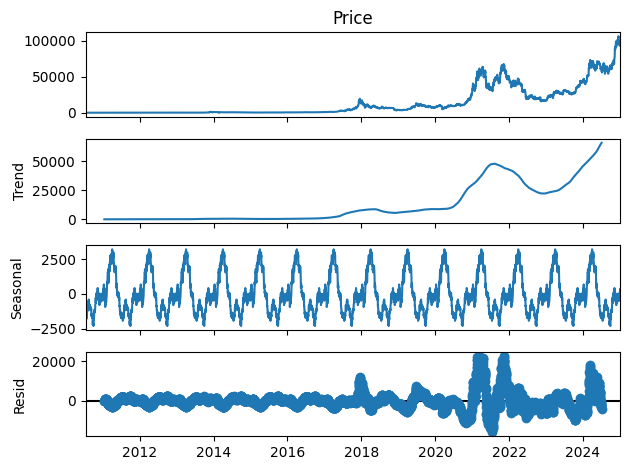

In [14]:
decomposition = seasonal_decompose(bitcoin['Price'], model='additive', period=365)
decomposition.plot()
plt.show()


Plot ACF and PACF

<Figure size 1200x600 with 0 Axes>

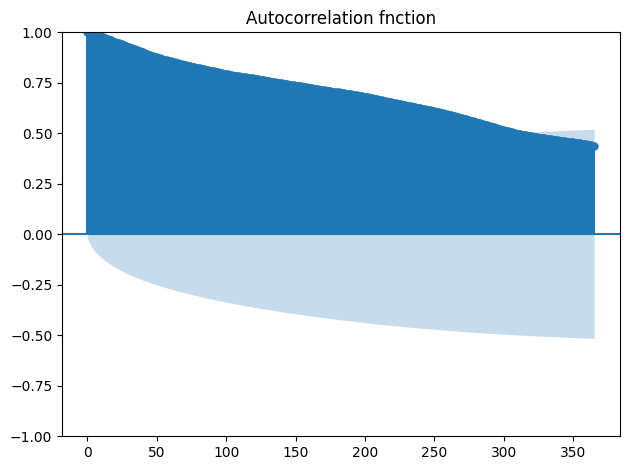

In [15]:
plt.figure(figsize=(12, 6))
plot_acf(bitcoin['Price'], lags=365)
plt.title("Autocorrelation fnction")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

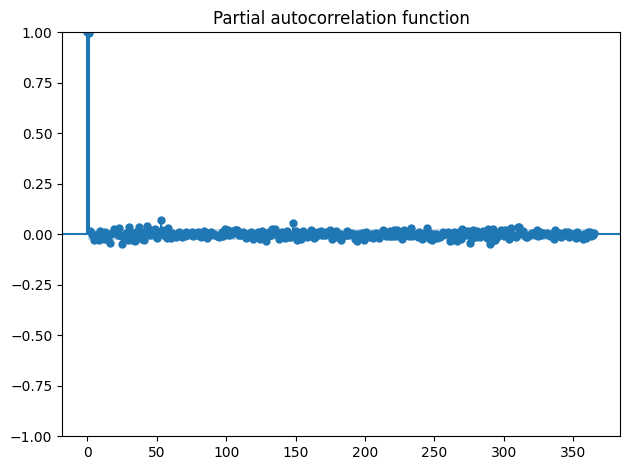

In [16]:
plt.figure(figsize=(12, 6))
plot_pacf(bitcoin['Price'], lags=365)
plt.title("Partial autocorrelation function")
plt.tight_layout()
plt.show()